In [1]:
# Requirements
import os
import pandas as pd
import numpy as np

import PIL
import PIL.Image
import pathlib
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import io
import random

In [2]:
# --- Unet parameters
numConvolutionFilters       = 32        # --- Number of convolution filters to learn
windowSize                  = 3         # --- Size of the convolution window
activationFunction          = "relu"    # --- Activation function
padding                     = "same"    # --- padding = "same" means padding with zeros evenly to the left/right or up/down of the input
pool_size                   = (2, 2)    # --- pool_size = (2, 2) will take the max value over a 2 x 2 pooling window when applying MaxPool2D

# --- Training parameters
numEpochs                   = 5         # --- Number of epochs
batchSize                   = 16        
optimizer                   = "Adam"
learningRate                = 1e-4      
trainEvaluationRatio        = 0.9       # --- trainEvaluationRatio = 0.9 means 90% training and 10% evaluation

#continueTraining            = False
continueTraining            = True      # --- True means that the training exploits the lastly optimized model
limitedData                 = True      # --- True means that not all the dataset images are used for training/evaluation. Some are used for final testing.

# --- Image shape
imageWidth, imageHeight, imageChannels = (512, 512, 1) 
imageShape                  = (imageWidth, imageHeight, imageChannels)
if limitedData == True:
    numTrainImages          = 400       # --- Number of images used in training/evaluation
numTestImages               = 100

# --- Signal to Noise Ratio of the noisy images
SNR                         = 10

In [3]:
# --- Paths
rootDataPath                = "/content/gdrive/MyDrive/Colab Notebooks/2D_denoising_FBP"
pathResults                 = os.path.join(rootDataPath, 'Results')
projectName                 = '2d_denoising_FBP'
modelName                   = '_model_last.h5'

# Continue training a model from checkpoint
if continueTraining == True:
    pathForegoingModel = os.path.join(pathResults, projectName, modelName)

from google.colab import drive
drive.mount("/content/gdrive")

# --- Create project root directory if it is non-existent and sets the project root directory as the current directory
if os.path.exists(rootDataPath) == False:
  os.mkdir(rootDataPath)
os.chdir(rootDataPath)
print('Current directory: ' + os.getcwd())

# --- Train and test dataset directories 
trainDatasetDirectoryString = os.path.join(rootDataPath, "Data/Train")
trainDatasetDirectoryPosix  = pathlib.Path(trainDatasetDirectoryString) 
testDatasetDirectoryString  = os.path.join(rootDataPath, "Data/Test")
testDatasetDirectoryPosix   = pathlib.Path(testDatasetDirectoryString) 

Mounted at /content/gdrive
Current directory: /content/gdrive/MyDrive/Colab Notebooks/2D_denoising_FBP


In [4]:
# --- Image visualization
def displaySlices(imageTuple, titles, figsize = (12, 4), nameSave = []):
    numDims    = len(imageTuple)
    fig, axarr = plt.subplots(1, numDims, figsize = figsize)
    fig.tight_layout()    
    for i in range(numDims):
        img0      = axarr[i].imshow(imageTuple[i], cmap = 'gray')
        divider   = make_axes_locatable(axarr[i])
        cax       = divider.append_axes("right", size="7%", pad=0.05)
        plt.colorbar(img0, cax = cax) 
        axarr[i].set_title(titles[i])
        axarr[i].axis('off')
    plt.show()
    if nameSave:
        fig.savefig(nameSave, dpi = 300, bbox_inches = 'tight') 
    return fig

In [5]:
# --- Train and test dataset filenames
fnamesTrainPosix            = list(trainDatasetDirectoryPosix.glob('*/*.png'))
fnamesTrainString           = [str(fname) for fname in fnamesTrainPosix]
fnamesTestPosix             = list(testDatasetDirectoryPosix.glob('*/*.png'))
fnamesTestString            = [str(fname) for fname in fnamesTestPosix]

# --- If the number of training images is unlimited, then this number is the number of image files.
if limitedData == False:
    numTrainImages  = len(fnamesTrainString)    
#else:
#    random.shuffle(fnamesTrainString)

Number of training dataset images  :  360
Number of evaluation dataset images:  40
Number of test dataset images      :  100
/content/gdrive/MyDrive/Colab Notebooks/2D_denoising_FBP/Data/Train/TrainImages/ellipse_1.png


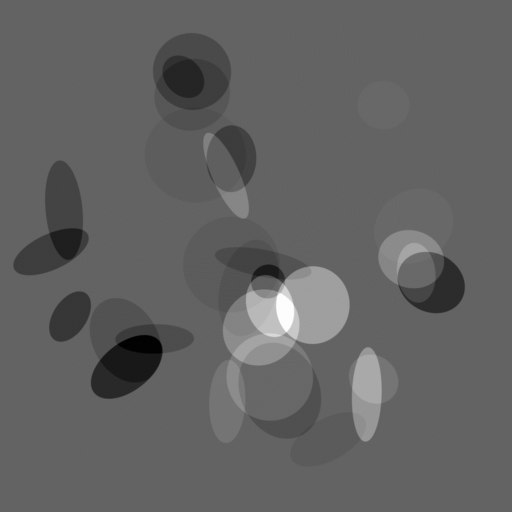

/content/gdrive/MyDrive/Colab Notebooks/2D_denoising_FBP/Data/Train/TrainImages/ellipse_2.png


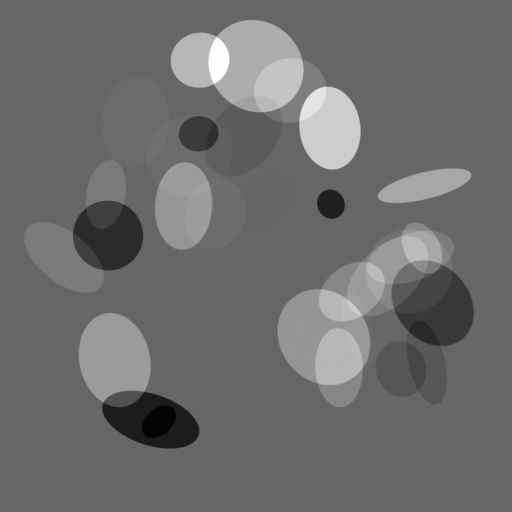

/content/gdrive/MyDrive/Colab Notebooks/2D_denoising_FBP/Data/Train/TrainImages/ellipse_3.png


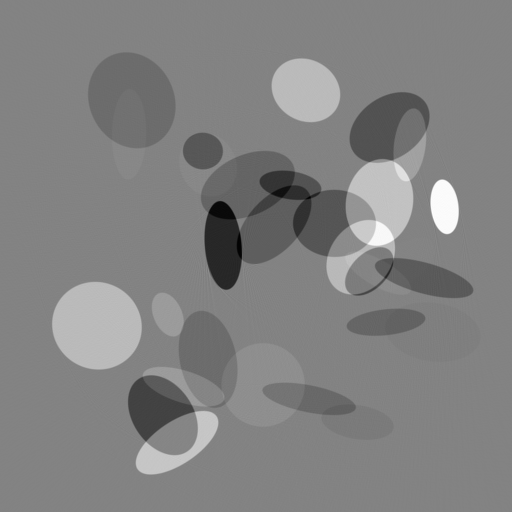

In [6]:
# --- Define the whole dataset and split it into train and evaluation datasets
wholeTrainDataset     = tf.data.Dataset.from_tensor_slices(fnamesTrainString[:numTrainImages]) 
trainDataset          = wholeTrainDataset.take(int(numTrainImages * trainEvaluationRatio))
evaluationDataset     = wholeTrainDataset.skip(int(numTrainImages * trainEvaluationRatio))

# --- Prepare test dataset
wholeTestDataset      = tf.data.Dataset.from_tensor_slices(fnamesTestString[:numTestImages])
testDataset           = wholeTestDataset.take(numTestImages)

print("Number of training dataset images  : ", trainDataset.cardinality().numpy())
print("Number of evaluation dataset images: ", evaluationDataset.cardinality().numpy())
print("Number of test dataset images      : ", testDataset.cardinality().numpy())

# --- Display three dataset images
if 1:
  for a in wholeTrainDataset.take(3):
      fname = a.numpy().decode("utf-8") 
      print(fname)
      display(PIL.Image.open(fname))

In [7]:
# --- Add Gaussian noise
def addGaussianNoise(img):
    imgNorm   = tf.norm(img)
    noise     = tf.random.normal(img.shape, mean = 0, stddev = 1)
    noiseNorm = tf.norm(noise)
    img_noisy = img + 10**(-SNR / 20) * imgNorm * noise / noiseNorm
    return img_noisy
    
# --- Convert image to float32
def convertImage(img):
    # --- Convert image to uint8 tensor
    img = tf.image.decode_png(img, imageChannels)
    # --- Convert unit8 tensor to floats in range [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [imageWidth, imageHeight])
    return img 

# --- Load and convert image
def loadAndConvertImage(file_path: tf.Tensor):
    img = tf.io.read_file(file_path)
    img = convertImage(img)
    return img 

In [8]:
# --- Transform train dataset
trainDataset = trainDataset.map(lambda x: loadAndConvertImage(x), num_parallel_calls = tf.data.AUTOTUNE)
# --- Add Gaussian noise to train dataset
trainDataset = trainDataset.map(lambda x: (addGaussianNoise(x), x), num_parallel_calls = tf.data.AUTOTUNE)
 
# --- Transform evaluation dataset
evaluationDataset = evaluationDataset.map(lambda x: loadAndConvertImage(x), num_parallel_calls = tf.data.AUTOTUNE)
# --- Add Gaussian noise to evaluation dataset
evaluationDataset = evaluationDataset.map(lambda x: (addGaussianNoise(x), x), num_parallel_calls = tf.data.AUTOTUNE)

# --- Transform test dataset
testDataset = testDataset.map(lambda x: loadAndConvertImage(x), num_parallel_calls = tf.data.AUTOTUNE)   
# --- Add Gaussian noise to evaluation dataset
testDataset = testDataset.map(lambda x: (addGaussianNoise(x), x), num_parallel_calls = tf.data.AUTOTUNE)

In [9]:
# --- Caching, prefetching and batching train dataset
# --- Cache keeps the data in RAM memory after the first epoch. Comment if not enough RAM is available.
# --- Prefetch allows to prepare data for next batch while the model is being trained for the current batch on the GPU. Remember that, using tf datasets, data (image slices) 
#     are automatically fetched and pre-processed from the given directories.
# --- Without .cache, the code is 23 % slower, and without .cache and .prefetch it is 64% slower
# --- .cache() keeps the images in memory after they are loaded off disk during the first epoch. 
trainDatasetBatched = trainDataset.cache().batch(batchSize)
# --- To randomize iteration order, call shuffle after calling cache.
trainDatasetBatched = trainDatasetBatched.shuffle(buffer_size = trainDataset.cardinality().numpy(), 
                                                  reshuffle_each_iteration = True,
                                                  seed = 50)
# --- .prefetch() overlaps data preprocessing and model execution while training
trainDatasetBatched = trainDatasetBatched.prefetch(tf.data.experimental.AUTOTUNE)  

# --- Caching, prefetching and batching evaluation dataset 
evaluationDatasetBatched = evaluationDataset.cache().batch(batchSize)
evaluationDatasetBatched = evaluationDatasetBatched.shuffle(buffer_size = evaluationDataset.cardinality().numpy(), 
                                                            reshuffle_each_iteration = True,
                                                            seed = 50)
evaluationDatasetBatched = evaluationDatasetBatched.prefetch(tf.data.experimental.AUTOTUNE)  

In [10]:
# --- Simple 2D U-Net
def unetModel(imageShape = [28, 28, 1], numConvolutionFilters = 32, windowSize = 3, activationFunction = "relu", padding = "same", pool_size = pool_size):
    
    convolutionArguments = {"activation": activationFunction, "padding": padding, "kernel_size": windowSize}
    
    input_ = Input(shape = imageShape)
    conv1 = Conv2D(filters = numConvolutionFilters, **convolutionArguments)(input_)
    conv2 = Conv2D(filters = numConvolutionFilters, **convolutionArguments)(conv1)
    pool1 = MaxPool2D(pool_size = pool_size)(conv2)
    #
    conv3 = Conv2D(filters = 2 * numConvolutionFilters, **convolutionArguments)(pool1)
    conv4 = Conv2D(filters = 2 * numConvolutionFilters, **convolutionArguments)(conv3)
    pool2 = MaxPool2D(pool_size = pool_size)(conv4)
    #
    conv5 = Conv2D(filters = 4 * numConvolutionFilters, **convolutionArguments)(pool2)
    conv6 = Conv2D(filters = 2 * numConvolutionFilters, **convolutionArguments)(conv5)
    up1 = UpSampling2D(size = (2, 2))(conv6)
    #
    conc1 = Concatenate()([conv4, up1])
    #
    conv7 = Conv2D(filters=2*numConvolutionFilters, **convolutionArguments)(conc1)
    conv8 = Conv2D(filters=numConvolutionFilters, **convolutionArguments)(conv7)
    up2 = UpSampling2D(size=(2,2))(conv8)
    #
    conc2 = Concatenate()([conv2, up2])
    #
    conv9 = Conv2D(filters=numConvolutionFilters, **convolutionArguments)(conc2)
    conv10 = Conv2D(filters=numConvolutionFilters, **convolutionArguments)(conv9)
    #
    output = Conv2D(filters=1, kernel_size=1, activation = None)(conv10)
    #
    model = keras.Model(inputs=[input_], outputs=[output])
    return model

In [11]:
if continueTraining == True:
    # --- Load previous model
    model = keras.models.load_model(pathForegoingModel) 
else:
    # --- Model definition
    model = unetModel(imageShape = imageShape, numConvolutionFilters = numConvolutionFilters, windowSize = windowSize, activationFunction = activationFunction, padding = padding, pool_size = pool_size)

    optimizer = keras.optimizers.Adam(learning_rate = learningRate)    
    model.compile(optimizer = optimizer, loss = keras.losses.MeanSquaredError(), metrics = ["mse"])         
         
model.summary()
#model.layers

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [12]:
# --- Model training
history = model.fit(trainDatasetBatched, epochs = numEpochs, validation_data = evaluationDatasetBatched)

Epoch 1/5
23/23 [==============================] - 48s 946ms/step - loss: 2.9505e-04 - mse: 2.9505e-04 - val_loss: 2.8096e-04 - val_mse: 2.8096e-04
Epoch 2/5
23/23 [==============================] - 17s 743ms/step - loss: 2.9280e-04 - mse: 2.9280e-04 - val_loss: 2.7328e-04 - val_mse: 2.7328e-04
Epoch 3/5
23/23 [==============================] - 17s 750ms/step - loss: 2.8719e-04 - mse: 2.8719e-04 - val_loss: 2.7090e-04 - val_mse: 2.7090e-04
Epoch 4/5
23/23 [==============================] - 18s 757ms/step - loss: 2.8694e-04 - mse: 2.8694e-04 - val_loss: 2.7409e-04 - val_mse: 2.7409e-04
Epoch 5/5
23/23 [==============================] - 18s 762ms/step - loss: 2.8163e-04 - mse: 2.8163e-04 - val_loss: 2.6708e-04 - val_mse: 2.6708e-04


In [13]:
# --- Saving model
if os.path.exists(pathResults) is False: 
    os.mkdir(pathResults)
model.save(os.path.join(pathResults, projectName, modelName))

Display training and evaluation losses. 

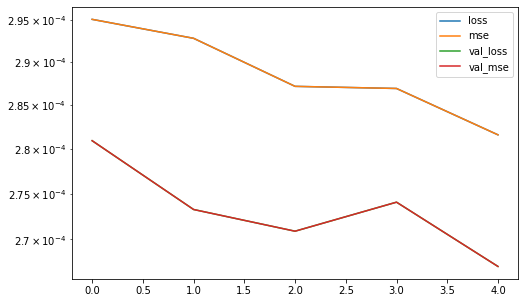

In [14]:
# --- Loss history
pd.DataFrame(history.history).plot(figsize=[8, 5], logy = True)
plt.show()

In [15]:
def unpackTestImages(testDataset, numTestImages):

    dataTest        = []
    dataTestNoisy   = []
    count = 0
    for a_n, a in testDataset.take(numTestImages):
        dataTestCurrent       = a.numpy()  
        dataTestNoisyCurrent  = a_n.numpy() 
        if count == 0:
            dataTest          = dataTestCurrent
            dataTestNoisy     = dataTestCurrent
            count             = 1
        else:            
            dataTest          = np.append(dataTest, dataTestCurrent, axis = 2)
            dataTestNoisy     = np.append(dataTestNoisy, dataTestNoisyCurrent, axis = 2)
    dataTest          = np.transpose(dataTest, (2, 0, 1))
    dataTestNoisy     = np.transpose(dataTestNoisy, (2, 0, 1))
    dataTest          = dataTest[:, :, :, np.newaxis] 
    dataTestNoisy     = dataTestNoisy[:, :, :, np.newaxis] 
    return dataTest, dataTestNoisy
    
# --- Unpack test data
dataTest, dataTestNoisy = unpackTestImages(testDataset, numTestImages)

Error 3.3


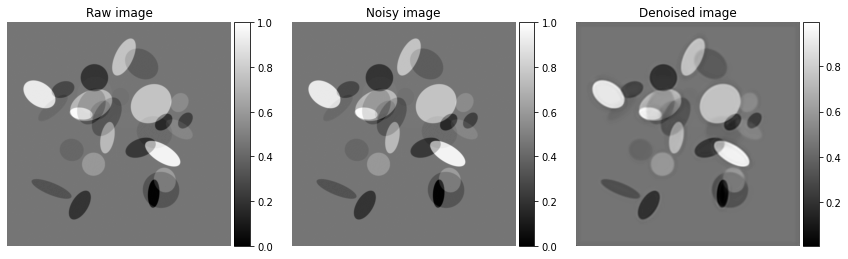

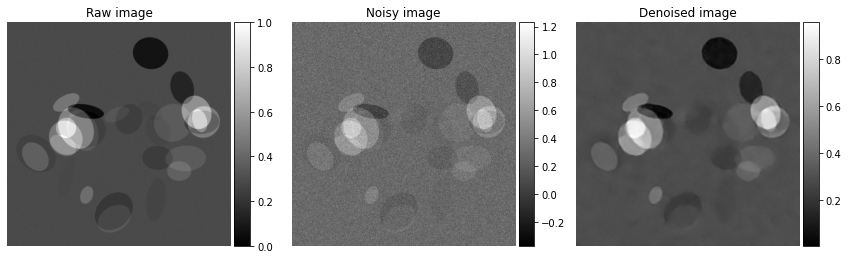

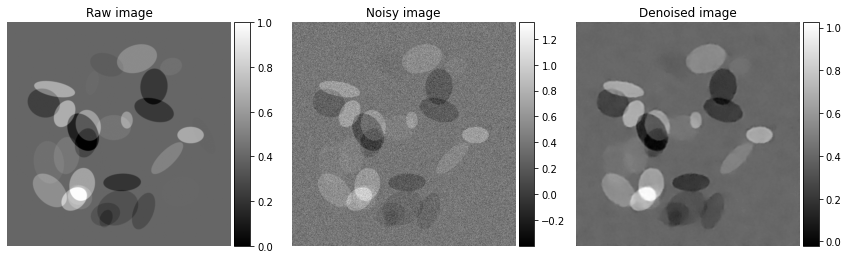

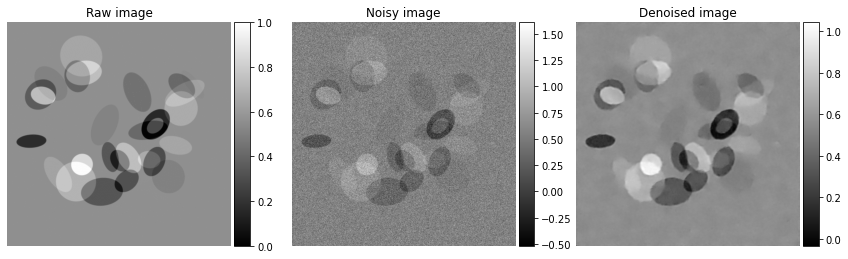

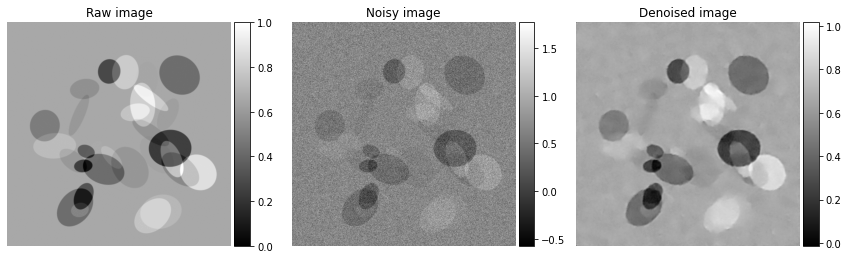

In [16]:
# --- Model prediction
predictedImages     = model.predict(dataTestNoisy)
predictedImagesErr  = np.mean(100 * np.linalg.norm(dataTest[:, :, :, 0] - predictedImages[:, :, :, 0], axis = (1, 2)) / np.linalg.norm(dataTest[:, :, :, 0], axis=(1, 2)))
print('Error %.1f' % predictedImagesErr)

# --- Display predicted result
for i in range(5):
    displaySlices([dataTest[i, :, :, 0], dataTestNoisy[i, :, :, 0], predictedImages[i, :, :, 0]], ['Raw image', 'Noisy image', 'Denoised image'], figsize = (12, 4),
                   nameSave = os.path.join(pathResults, projectName + '_test_ex' + str(i) + '.png'))
